In [1]:

!pip install opendatasets
!pip install pandas


In [2]:
import opendatasets as od
import pandas as pd
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [3]:
IMAGE_SIZE = [224, 224]

train_path = '/Users/suchitsharma/Downloads/Lung Disease Dataset/train'
valid_path = '/Users/suchitsharma/Downloads/Lung Disease Dataset/test'

In [4]:
from tensorflow.keras.applications.resnet import ResNet101
ress = ResNet101(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in ress.layers:
  layer.trainable = False

2023-07-02 13:20:02.945608: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-07-02 13:20:02.945633: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-07-02 13:20:02.945639: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-07-02 13:20:02.945713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-02 13:20:02.945963: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
 # useful for getting number of classes
folders = glob('/Users/suchitsharma/Downloads/Lung Disease Dataset/train/*')

x = Flatten()(ress.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=ress.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/Users/suchitsharma/Downloads/Lung Disease Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/Users/suchitsharma/Downloads/Lung Disease Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 6054 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [7]:
len(folders)

5

In [8]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


In [9]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),callbacks=[early]
)


/var/folders/1r/d9gtx_q511v7f19mk0_z468r0000gn/T/ipykernel_787/2454260412.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/30


2023-07-02 13:20:09.603473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - ETA: 0s - loss: 1.6794 - accuracy: 0.4547

2023-07-02 13:23:43.678461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


190/190 [==============================] - 280s 1s/step - loss: 1.6794 - accuracy: 0.4547 - val_loss: 0.9309 - val_accuracy: 0.6311
Epoch 2/30
190/190 [==============================] - 276s 1s/step - loss: 1.1975 - accuracy: 0.5558 - val_loss: 1.0537 - val_accuracy: 0.6321
Epoch 3/30
190/190 [==============================] - 275s 1s/step - loss: 1.1217 - accuracy: 0.5727 - val_loss: 0.9815 - val_accuracy: 0.6138
Epoch 4/30
190/190 [==============================] - 275s 1s/step - loss: 1.0015 - accuracy: 0.6165 - val_loss: 1.1225 - val_accuracy: 0.5906
Epoch 5/30
190/190 [==============================] - 277s 1s/step - loss: 1.0469 - accuracy: 0.6044 - val_loss: 1.2794 - val_accuracy: 0.5319
Epoch 6/30
190/190 [==============================] - 276s 1s/step - loss: 1.0352 - accuracy: 0.6237 - val_loss: 0.9921 - val_accuracy: 0.6519
Epoch 7/30
190/190 [==============================] - 277s 1s/step - loss: 1.0957 - accuracy: 0.6103 - val_loss: 0.9073 - val_accuracy: 0.6696
Epoch 8/30

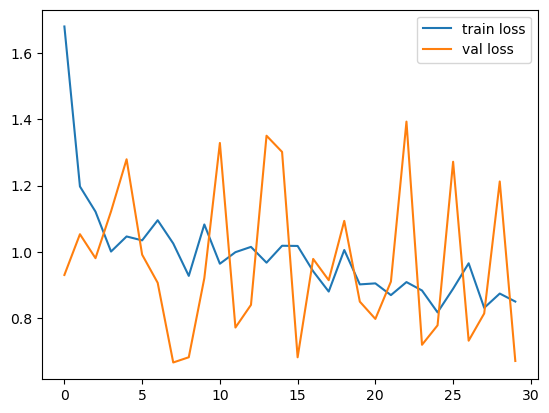

<Figure size 640x480 with 0 Axes>

In [10]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


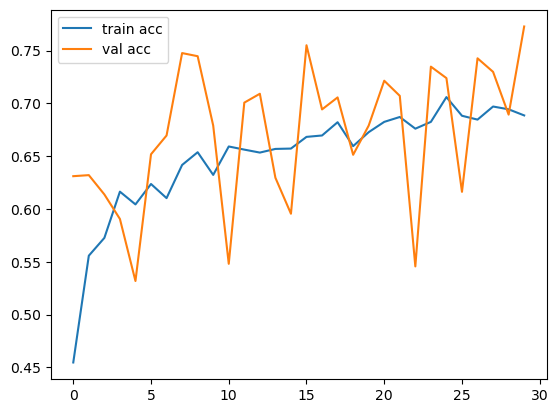

<Figure size 640x480 with 0 Axes>

In [11]:

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Y_pred = model.predict_generator(test_set, test_set.samples //
32+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

/var/folders/1r/d9gtx_q511v7f19mk0_z468r0000gn/T/ipykernel_787/2919555015.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_set, test_set.samples //
2023-07-02 15:30:08.464313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Confusion Matrix
[[ 74  71  88 105  65]
 [ 65  74 105  91  72]
 [ 67  69  95  97  76]
 [ 88  78  73  95  74]
 [ 83  70  93 102  55]]
